In [ ]:
from PIL import Image, ImageDraw

def draw_bbox_on_image(image_path, bboxes, labels=None, box_color="red", width=3, show=True, save_path=None):
    """
    Draw bounding boxes on an image using Pillow.

    Parameters:
        image_path (str): Path to the image.
        bboxes (List[List[float]]): List of bounding boxes in COCO format: [x, y, width, height].
        labels (List[str] or None): Optional list of labels to display with boxes.
        box_color (str or tuple): Color of bounding boxes.
        width (int): Line width of the box.
        show (bool): Whether to display the image.
        save_path (str or None): If set, saves the resulting image to this path.
    """
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        draw.rectangle([x, y, x + w, y + h], outline=box_color, width=width)

        if labels and i < len(labels):
            draw.text((x, y - 10), labels[i], fill=box_color)

    if show:
        image.show()

    if save_path:
        image.save(save_path)

    return image


In [20]:
import pandas as pd
import json

with open('/home/sakal/Documents/object-detection-on-raspberry-pi/Dataset/TACO/data/annotations.json', 'r') as f:
    coco_data = json.load(f)

In [21]:
coco_data['images'][0]

{'id': 0,
 'width': 1537,
 'height': 2049,
 'file_name': 'batch_1/000006.jpg',
 'license': None,
 'flickr_url': 'https://farm66.staticflickr.com/65535/33978196618_e30a59e0a8_o.png',
 'coco_url': None,
 'date_captured': None,
 'flickr_640_url': 'https://farm66.staticflickr.com/65535/33978196618_632623b4fc_z.jpg'}

In [1]:
import json
from PIL import Image, ImageDraw
import os

def visualize_single_image_annotation(data):

    image_path = data['Path']
    bboxes = data['Bbox']

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for bbox in bboxes:
        x, y, w, h = bbox
        draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

    image.show()
        
def get_grouped_class(class_name):
    class_name = class_name.strip()
    grouped_classes = {
        "Metal": [
            "Metal bottle cap", "Metal lid", "Drink can", "Pop tab", "Scrap metal",
            "Food Can", "Aluminium blister pack", "Aluminium foil", "Aerosol"
        ],
        "Plastic": [
            "Plastic bottle cap", "Other plastic wrapper", "Six pack rings",
            "Single-use carrier bag", "Plastic straw", "Plastic glooves",
            "Plastic utensils", "Disposable plastic cup", "Other plastic bottle",
            "Tupperware", "Spread tub", "Garbage bag", "Other plastic container",
            "Other plastic", "Rope & strings", "Other plastic cup", "Plastic film",
            "Polypropylene bag", "Plastic lid", "Clear plastic bottle", "Squeezable tube",
            "Carded blister pack", "Crisp packet", "Meal carton"
        ],
        "Paper": [
            "Paper cup", "Paper bag", "Normal paper", "Paper straw", "Tissues",
            "Toilet tube", "Wrapping paper", "Pizza box", "Magazine paper",
            "Corrugated carton", "Egg carton", "Other carton", "Drink carton"
        ],
        "Glass": [
            "Glass jar", "Glass bottle", "Glass cup", "Broken glass"
        ],
        "Waste": [
            "Cigarette", "Food waste", "Foam cup",
            "Disposable food container", "Foam food container",
            "Shoe", "Unlabeled litter", "Styrofoam piece"
        ],
        "Battery": [
            "Battery"
        ],
    }

    for group, items in grouped_classes.items():
        if class_name in items:
            return group
    print(f"Class '{class_name}' not found in grouped classes.")
    return "Other"        

def extract_annotations(json_path, image_dir, image_id=None, convert=False):
    with open(json_path, 'r') as f:
        data = json.load(f)
    labels = []
    # Select image
    images = data['images']
    annotations = data['annotations']
    categories = {cat['id']: cat['name'] for cat in data['categories']}

    for img in images:
        if image_id and img['id'] != image_id:
            continue

        image_path = os.path.join(image_dir, img['file_name'])
        size = (img['width'], img['height'])
        bboxes = []
        classes = []
        for ann in annotations:
            if ann['image_id'] != img['id']:
                continue
            bboxes.append(ann['bbox'])
            if convert:
                class_name = categories[ann['category_id']]
                grouped_class = get_grouped_class(class_name)
                classes.append(grouped_class)
            else:
                classes.append(categories[ann['category_id']])
                
        label = {"Path": image_path,
                 "Size": size,
                 "Bbox": bboxes,
                 "Class": classes}
                                
        labels.append(label)
    return labels

In [2]:
extracted_trash = extract_annotations(
    '/home/sakal/Documents/object-detection-on-raspberry-pi/Dataset/Trash Detection.v14i.coco/train/_annotations.coco.json',
    '/home/sakal/Documents/object-detection-on-raspberry-pi/Dataset/Trash Detection.v14i.coco/train',
    convert=False
)

extracted_taco = extract_annotations(
    '/home/sakal/Documents/object-detection-on-raspberry-pi/Dataset/TACO/data/annotations.json',
    '/home/sakal/Documents/object-detection-on-raspberry-pi/Dataset/TACO/data',
    convert=True
)

classes_names_trash = []
for label in extracted_trash:
    classes_names_trash.extend(label['Class'])
classes_names_trash = list(set(classes_names_trash))

classes_names_taco = []
for label in extracted_taco:
    classes_names_taco.extend(label['Class'])
classes_names_taco = list(set(classes_names_taco))

In [3]:
classes_names_taco

['Paper', 'Glass', 'Waste', 'Plastic', 'Metal', 'Battery']

In [4]:
from models.detector_model.my_yolo import YOLOTrainingProcessor

classes_names = []
for label in extracted_taco:
    classes_names.extend(label['Class'])
classes_names = list(set(classes_names))

processor = YOLOTrainingProcessor(
    input_size=448,
    grid_size=7,
    classes=classes_names_taco,
    num_anchors=3
)

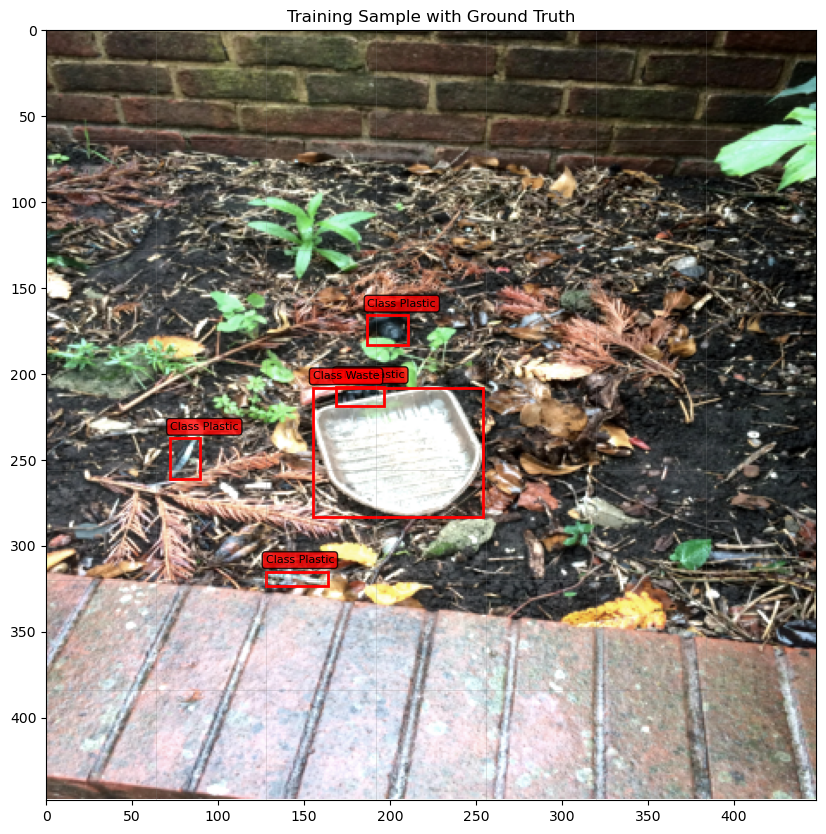

In [8]:
image_tensor, target_tensor, anchor_pose = processor.process_training_sample(
    extracted_taco[1060],
    apply_augmentation=True,
    get_anchors=True
)

processor.visualize_training_sample(
    image_tensor,
    target_tensor,
    anchors_pose=anchor_pose
)

In [30]:
# Visualize
# processor.visualize_training_sample(image_tensor, target_tensor)

# image_paths = ['img1.jpg', 'img2.jpg', ...]
# annotation_paths = ['ann1.xml', 'ann2.xml', ...]

# dataset = YOLODataset(
#     image_paths, annotation_paths, processor, 
#     annotation_format='pascal_voc', is_training=True
# )

# dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# # Training loop example
# for batch_idx, (images, targets) in enumerate(dataloader):
#     # images: [batch_size, 3, 448, 448]
#     # targets: [batch_size, 7, 7, 25]
#     print(f"Batch {batch_idx}: Images {images.shape}, Targets {targets.shape}")

In [51]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn

train_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

class YOLO(nn.Module):
    def __init__(self, num_classes=20, num_anchors=3, grid_size=7):
        super(YOLO, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.grid_size = grid_size

        # Backbone: Feature extractor (e.g., simplified CNN for demonstration)
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Detection Head: Outputs bounding boxes, confidence scores, and class probabilities
        self.detector = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((grid_size, grid_size)),
            nn.Flatten(),
            nn.Linear(256 * grid_size * grid_size, grid_size * grid_size * (num_anchors * 5 + num_classes)),
        )

    def forward(self, x):
        features = self.backbone(x)
        predictions = self.detector(features)
        return predictions.view(-1, self.grid_size, self.grid_size, self.num_anchors * 5 + self.num_classes)

In [52]:
model = YOLO(num_classes=10)

In [53]:
from PIL import Image

input = train_transforms(Image.open('../Dataset/Trash Detection.v14i.coco/test/000000_jpg.rf.d63f280021dbe6bf447fa7848040a8a4.jpg'))
input.shape

torch.Size([3, 448, 448])

In [54]:
model(input.unsqueeze(0)).shape

torch.Size([1, 7, 7, 25])